In [347]:
#!pip install tqdm
#!pip install nltk
#!pip install gensim
#!pip install transformers

#!pip install gensim
#!pip install --upgrade numpy
#!pip install --upgrade --force-reinstall gensim
#!pip install wordcloud

import pandas as pd
import json
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import classification_report, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from itertools import cycle


import nltk
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from wordcloud import WordCloud

import gensim
import gensim.downloader as gensim_api
import transformers
import os
import re
import nltk
import tensorflow as tf

from bertopic import BERTopic
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

import random

# disable warning
import warnings
warnings.filterwarnings("ignore")

### File with Questions Only

In [145]:
# Load JSON file with question only into a Pandas DataFrame
with open("download_fix/nlp_questions_only.json", "r") as f:
    data = json.load(f)

# Convert JSON data to DataFrame
df_questions = pd.DataFrame(data)
df_questions["tags"] = df_questions["tags"].apply(lambda x: ", ".join(x))

df_questions.head()

,tags,title,body,creation_date,view_count,score,accepted_answer_id
0,"nlp, large-language-model, tf-idf, tfidfvector...",Difference between TfIdf vectorizer and kwx,I am looking at querying a text database based...,2025-03-12 02:19:59,8,0,NaN
1,"python, pytorch, nlp, large-language-model",Calculate the gradient with respect to attenti...,I would like to return the gradient with respe...,2025-03-11 15:21:57,33,0,NaN
2,"python, nlp, large-language-model",Store images instead of showing in a server,I am running the code found on this [site][1] ...,2025-03-11 14:50:31,23,0,79501337.0
3,"python, regex, string, nlp",Split a string into separate words without spa...,My task is to split a string that does not hav...,2025-03-11 06:57:04,68,-5,NaN
4,"nlp, large-language-model",Comparing the similarity of spoken and written...,I'm converting spoken form text to its written...,2025-03-10 18:55:59,13,0,NaN


### File with Questions and Accepted Answers

In [207]:
# Load JSON file with accepted answer into a Pandas DataFrame
with open("download_fix/questions_and_answers.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Convert to DataFrame
df_qa = pd.DataFrame(data)

# Convert list of tags to a string for better readability
df_qa["tags"] = df_qa["tags"].apply(lambda x: ", ".join(x))

df_qa.head()

,tags,title,body,creation_date,view_count,score,accepted_answer_id,accepted_answer,accepted_answer_votes
0,"python, nlp, large-language-model",Store images instead of showing in a server,I am running the code found on this [site][1] ...,2025-03-11 14:50:31,23,0,79501337,I can't test it but ... I checked source code ...,1
1,"python, nlp, spacy, langchain, presidio",Presidio with Langchain Experimental does not ...,I am using presidio/langchain_experimental to ...,2025-03-03 22:27:07,129,4,79495969,After some test I was able to find the solutio...,-1
2,"nlp, opennlp",OpenNLP POSTaggerME and ChunkerME synergy,I'm trying to use the OpenNLP chunking API to ...,2025-02-22 16:06:11,31,1,79475445,"Q1 Yes, the chosen tag set (UD, Penn, custom) ...",1
3,"keras, deep-learning, nlp, lstm, sentiment-ana...",Underfitting Pre-Trained Glove + LSTM Model: A...,I am doing a sentiment classification using Pr...,2025-02-07 02:48:25,43,-1,79425201,"Based on extra information in the comments, I'...",0
4,"gcc, cmake, nlp, g++",Can&#39;t compile Marian NMT,I'm using endeavouros. I'm trying to compile M...,2025-01-05 06:04:59,60,4,79332711,"The diagnostic that your build is tripping, Wt...",4


### Statistical Detail of Collected Data

In this section, we explore the statistical detail of our dataset, such as data over year distribution, and word counts.

There are 11935 StackOverflow posts with tag NLP that have no accepted answer.
There are 8165 StackOverflow posts with tag NLP that have an accepted answer.


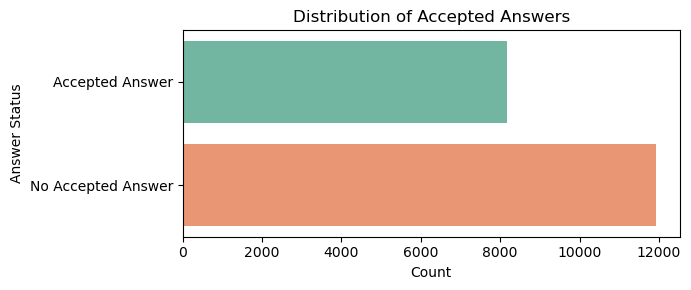

In [208]:
# Print counts
num_no_answer = df_questions["accepted_answer_id"].isna().sum()
num_with_answer = len(df_questions) - num_no_answer

print(f"There are {num_no_answer} StackOverflow posts with tag NLP that have no accepted answer.")
print(f"There are {num_with_answer} StackOverflow posts with tag NLP that have an accepted answer.")

# Plot as horizontal bar
plt.figure(figsize=(7, 3))
sns.countplot(y=df_questions["accepted_answer_id"].isna(), palette="Set2")

plt.title("Distribution of Accepted Answers")
plt.ylabel("Answer Status")
plt.xlabel("Count")
plt.yticks([0, 1], ["Accepted Answer", "No Accepted Answer"])
plt.tight_layout()
plt.show()


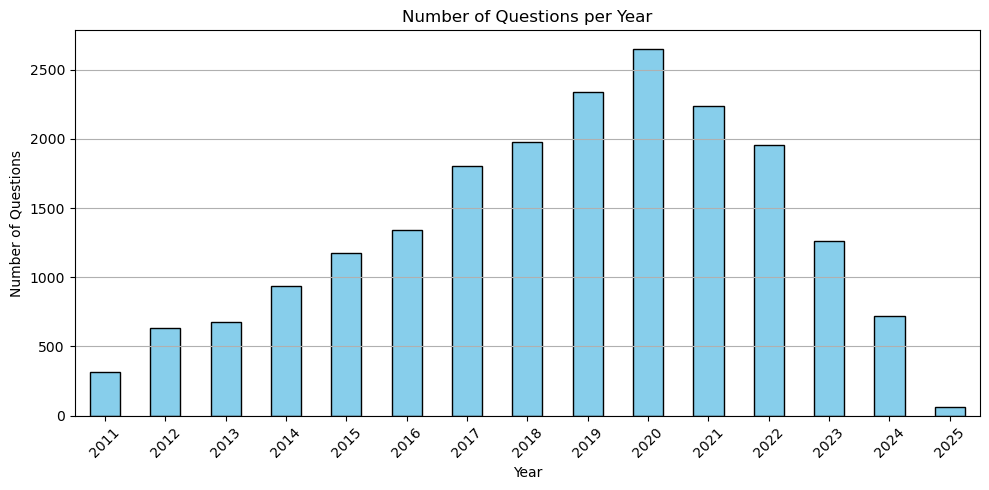

In [209]:
# Number of questions per year
df_questions['creation_date'] = pd.to_datetime(df_questions['creation_date'])
df_questions['year'] = df_questions['creation_date'].dt.year

# Group by year and count the number of posts
yearly_counts = df_questions.groupby('year').size()

# Plot as a bar chart
plt.figure(figsize=(10, 5))
yearly_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Number of Questions per Year")
plt.xlabel("Year")
plt.ylabel("Number of Questions")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [157]:
# View count statistics
df_questions['view_count'].describe()

count     20100.000000
mean       1901.336766
std        8367.616334
min           7.000000
25%         155.000000
50%         476.000000
75%        1333.000000
max      468162.000000
Name: view_count, dtype: float64

In [158]:
# Get the post with the most views
most_viewed_post = df_questions.loc[df_questions['view_count'].idxmax()]
print(f"The post with the most views is:\n{most_viewed_post['title']}")

The post with the most views is:
spacy Can&#39;t find model &#39;en_core_web_sm&#39; on windows 10 and Python 3.5.3 :: Anaconda custom (64-bit)


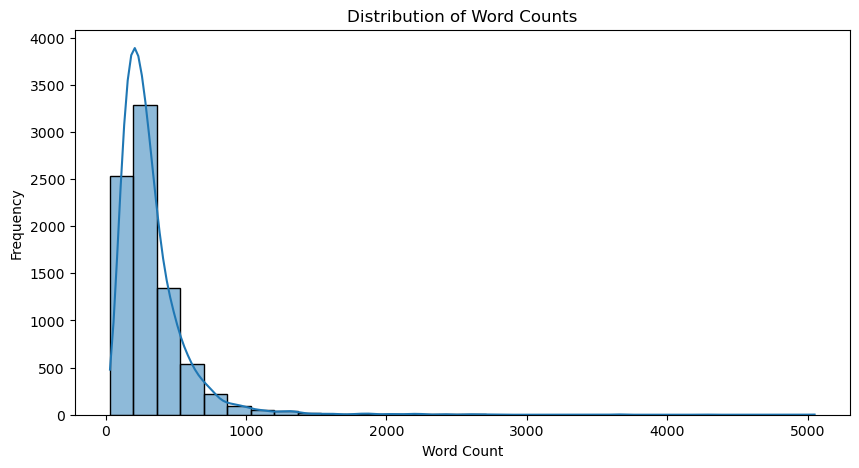

In [210]:
# Word count distribution
def plot_word_count_distribution(text_list):
    '''
    Plot the distribution of word counts in the text list.
    
    Args:
        text_list (list): A list of raw text strings.
    '''
    # Calculate word counts
    word_counts = [len(text.split()) for text in text_list]

    # Plot histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(word_counts, bins=30, kde=True)
    plt.title("Distribution of Word Counts")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()


# Plot the distribution of word counts
all_combined_text = df_qa['title'] + ' ' + df_qa['body'] + ' ' + df_qa['accepted_answer']
plot_word_count_distribution(all_combined_text.tolist())

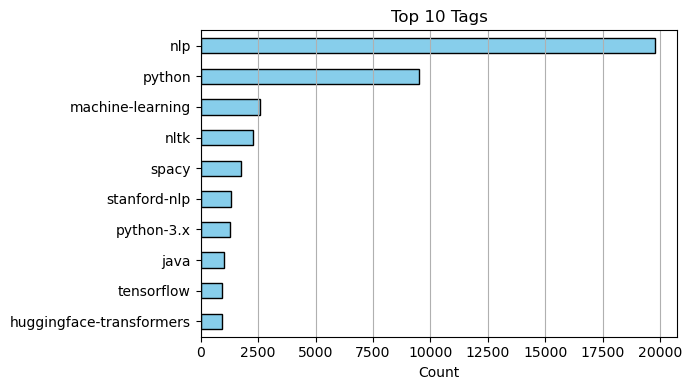

In [211]:
# Count the number of unique tags and their occurrences
all_tags = df_questions['tags'].dropna().apply(lambda x: [tag.strip() for tag in x.split(',')])

# Flatten the list of lists
flat_tags = [tag for sublist in all_tags for tag in sublist]

# Count each tag
tag_counts = pd.Series(flat_tags).value_counts()

# Plot top 10 tags as a horizontal bar chart
plt.figure(figsize=(7, 4))
top_tags = tag_counts.head(10)
top_tags.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Top 10 Tags")
plt.xlabel("Count")
plt.gca().invert_yaxis()  # Highest count at the top
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### INITIAL TEXT PREPROCESSING AND TOPIC EXTRACTION

In this part, we will do several preprocessing steps:
- Filter HTML tag : To get rid the unnecessary tags that are irrelevant to the semantic meaning of our post.
- Filter Code Snippets : Code snippet will take space of our embedding token, thus we will focus on the sentence only in the post.

In [363]:
# Get the necessary column from our df
columns = ["title", "body", "tags", "accepted_answer"]
df = df_qa[columns].copy()
df.head()

,title,body,tags,accepted_answer
0,Store images instead of showing in a server,I am running the code found on this [site][1] ...,"python, nlp, large-language-model",I can't test it but ... I checked source code ...
1,Presidio with Langchain Experimental does not ...,I am using presidio/langchain_experimental to ...,"python, nlp, spacy, langchain, presidio",After some test I was able to find the solutio...
2,OpenNLP POSTaggerME and ChunkerME synergy,I'm trying to use the OpenNLP chunking API to ...,"nlp, opennlp","Q1 Yes, the chosen tag set (UD, Penn, custom) ..."
3,Underfitting Pre-Trained Glove + LSTM Model: A...,I am doing a sentiment classification using Pr...,"keras, deep-learning, nlp, lstm, sentiment-ana...","Based on extra information in the comments, I'..."
4,Can&#39;t compile Marian NMT,I'm using endeavouros. I'm trying to compile M...,"gcc, cmake, nlp, g++","The diagnostic that your build is tripping, Wt..."


In [204]:
# Function to clean HTML tags and remove newline characters
def clean_html_tag(text):
    '''
    Function to clean HTML tags and remove newline characters
    Args:
    text: str: The input text to be cleaned
    Returns:
    str: The cleaned text
    '''

    # Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, "html5lib")
    text = soup.get_text()
    return text.replace("\n", " ").strip()

def clean_code_snippets(text):
    '''
    Function to clean code snippets from the text
    Args:
    text: str: The input text to be cleaned
    Returns:
    str: The cleaned text
    '''
    # Remove code snippets enclosed in triple backticks
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)
    # Remove code snippets enclosed in single backticks
    text = re.sub(r'`[^`]+`', '', text)
    # Remove code snippets enclosed in angle brackets
    text = re.sub(r'<[^>]+>', '', text)
    # Remove code snippets enclosed in parentheses
    text = re.sub(r'\([^)]*\)', '', text)
    # Remove code snippets enclosed in square brackets
    text = re.sub(r'\[[^\]]*\]', '', text)
    # Remove code snippets enclosed in curly braces
    text = re.sub(r'\{[^}]*\}', '', text)
    # Remove code snippets enclosed in quotes
    text = re.sub(r'\".*?\"', '', text)
    # Remove code snippets enclosed in single quotes
    text = re.sub(r'\'.*?\'', '', text)
    return text

In [222]:
df['title'] = df['title'].apply(clean_html_tag)
df['body'] = df['body'].apply(clean_html_tag).apply(clean_code_snippets)
df['tags'] = df['tags'].apply(clean_html_tag)
df['accepted_answer'] = df['accepted_answer'].apply(clean_html_tag).apply(clean_code_snippets)

# Check the cleaned data
df.head()

,title,body,tags,accepted_answer
0,Store images instead of showing in a server,I am running the code found on this in my ser...,"python, nlp, large-language-model","I cant show it but it should only get fig, ax...."
1,Presidio with Langchain Experimental does not ...,I am using presidio/langchain_experimental to ...,"python, nlp, spacy, langchain, presidio",After some test I was able to find the solutio...
2,OpenNLP POSTaggerME and ChunkerME synergy,It produced such good results. I was trying to...,"nlp, opennlp","Q1 Yes, the chosen tag set has an impact. Con..."
3,Underfitting Pre-Trained Glove + LSTM Model: A...,I am doing a sentiment classification using Pr...,"keras, deep-learning, nlp, lstm, sentiment-ana...","Based on extra information in the comments, Im..."
4,Can't compile Marian NMT,Im trying to compile Marian with these instruc...,"gcc, cmake, nlp, g++","The diagnostic that your build is tripping, Wt..."


TEXT SUMMARIZATION TO GET BETTER REPRESENTATION OF THE POST (USING T5 Pre-Trained MODEL)

This additional step is needed, as it is easier to get the overall meaning or what exactly a post discuss throught its summary. In this summarization, we use pretrained T5 model. The reason of why we use this model is in the report.

In [ ]:
## We want to extract summary from the title, body and accepted_answer to get the most relevant information for topic design 
combined_text = df['title'] + '.' + df['body'] + '.' + df['accepted_answer']

# Load the T5 tokenizer and model
tokenizer=AutoTokenizer.from_pretrained('T5-base')
model_summary=AutoModelWithLMHead.from_pretrained('T5-base', return_dict=True)

In [ ]:
# choose 100 random documents and summarize them
random.seed(42)
random_indices = random.sample(range(0, 8000), 100)
text_summary = []

for i in random_indices:
    sequence = combined_text[i]
    inputs=tokenizer.encode("sumarize: " +sequence,return_tensors='pt', max_length=512, truncation=True)
    output = model_summary.generate(inputs, min_length=100, max_length=200,early_stopping=True,
                            repetition_penalty=2.0,
                            length_penalty=1.0,
                            no_repeat_ngram_size=3)
    summary=tokenizer.decode(output[0])
    text_summary.append(summary)

# Select text summary from 0-100 and 134 to end
indices_fix = random_indices

In [ ]:
# Select df with the same indices in indices_fix
df_summarized = df.iloc[indices_fix].copy()
df_summarized['summary'] = text_summary
df_summarized.head()

,title,body,tags,accepted_answer,summary
5238,Lemmatizing Italian sentences for frequency co...,I would like to lemmatize some Italian text in...,"python-2.7, nlp, nltk, stemming, lemmatization",It know a lot about italian! 1) As far as I kn...,<pad> nltk should be used to lemmatize Italian...
912,What does padding do in keras,What does padding argument do in keras? In NLP...,"python, tensorflow, keras, nlp, conv-neural-ne...",With pad_sequences it simply indicates whether...,<pad> True<extra_id_20> keras padding argument...
204,How to format Ragged Tensor for Encoder-Decode...,Im not able to format my labels such that it i...,"python, tensorflow, keras, deep-learning, nlp","Reposting from above comment, to fix the above...",<pad> False omission: not all labels are of th...
6074,How can I effectively build a sentiment model ...,I’m interested in training a new sentiment mod...,"nlp, stanford-nlp",Here is some sample code I wrote to go through...,"<pad> java.io: ""java.util"" is a class that can..."
2253,What does Keras Tokenizer num_words specify?,Given this piece of code: from tensorflow.kera...,"python, tensorflow, machine-learning, keras, nlp",word_index it's simply a mapping of words to i...,<pad> tokenizer num_words is used to map words...


In [645]:
# Remove <pad> and </s> tokens from the summary
df_summarized['summary'] = df_summarized['summary'].str.replace('<pad>', '').str.replace('</s>', '')

# Check the summary
df_summarized['summary'].iloc[0]

' nltk should be used to lemmatize Italian sentences for frequency counting . in italian some articles are rendered with an "apostrophe" so "apparmentamento" is actually 2 words: "l\'appartalito". I am not sure how to do this because each word is lemmated by itself, not within the context of syllabi - pattern ? it would be better to use pattern to tokenize a sentence and then retrieve the lemmmatized word if possible '

In [255]:
# Save the summarized DataFrame to a CSV file
df_summarized.to_csv("download_fix/stack_overflow_summarized.csv", index=False)

Upon reading the summary thoroughly, we decide to design our topics or labels with the following:

- **Text Preprocessing** 
- **Python NLP Libraries**
- **POS and NER**
- **NLP Implementation in Java**
- **Pandas Implementation for NLP**
- **Text Feature Extraction**
- **Sentiment Analysis**
- **Unsupervised Text Classification**

Each of the topic will be represented by its description, and the description consist of several sentences that best describe the topic. These description sentences also contain keywords that are related to the topic.

## Text Preprocessing and Visualization

In [220]:
def text_preprocess(text):
    '''
    Preprocess text for NLP tasks
    Args:
      text (str): The input text to preprocess.
    Returns:
      list: A list of preprocessed tokens.
    '''
    # Remove polite or non-informative phrases
    text = re.sub(
        r'\b(thank(s| you| you very much)?|thanks in advance|any help (is|would be)? (appreciated|great)|'
        r'i (really )?need help|please help|can (someone|anyone) help|help me please|appreciate (any|your) help)\b',
        '', text, flags=re.IGNORECASE)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lower case and strip whitespace
    text = text.lower().strip()
    
    # Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text)

    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Stopwords removal
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

import matplotlib.patches as patches
def visualize_data_wordcloud(text_list, title='Word Cloud'):
    text_combined = ' '.join(text_list)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)

    # Add border
    ax = plt.gca()
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=3, edgecolor='black', facecolor='none'
    )
    ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

In [ ]:
# Preprocess the text data
df['body'] = df['body'].apply(text_preprocess)
df['title'] = df['title'].apply(text_preprocess)
df['accepted_answer'] = df['accepted_answer'].apply(text_preprocess)
df['tags'] = df['tags'].apply(text_preprocess)

We use wordcloud for word distribution visualization. We visualized two wordcloud, one with title only, and another with both title and body. We plot both of them because we are interested in what words are the most common in title and in the question body.

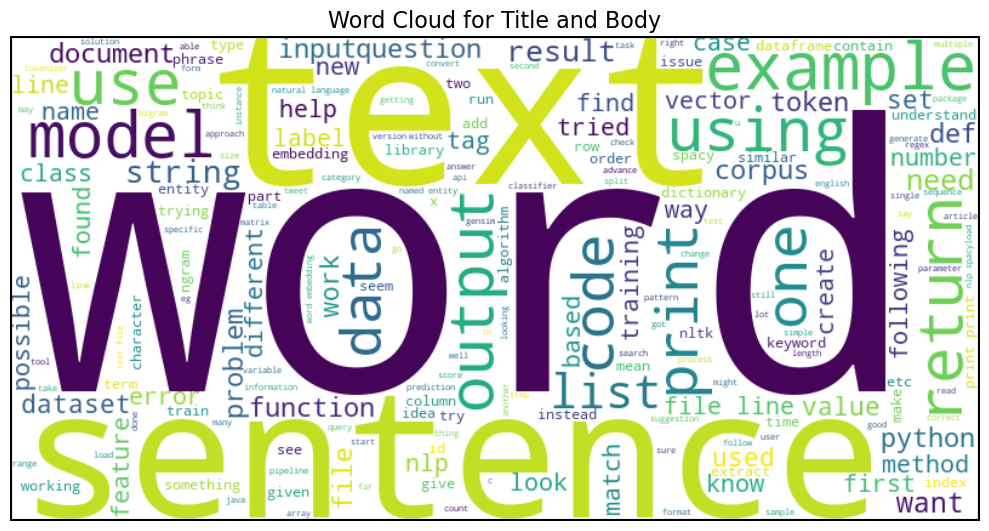

In [234]:
# Combine title and body
text = df['title'].apply(lambda x: ' '.join(x)) + ' ' + df['body'].apply(lambda x: ' '.join(x))

# Create a word cloud
visualize_data_wordcloud(text, title='Word Cloud for Title and Body')

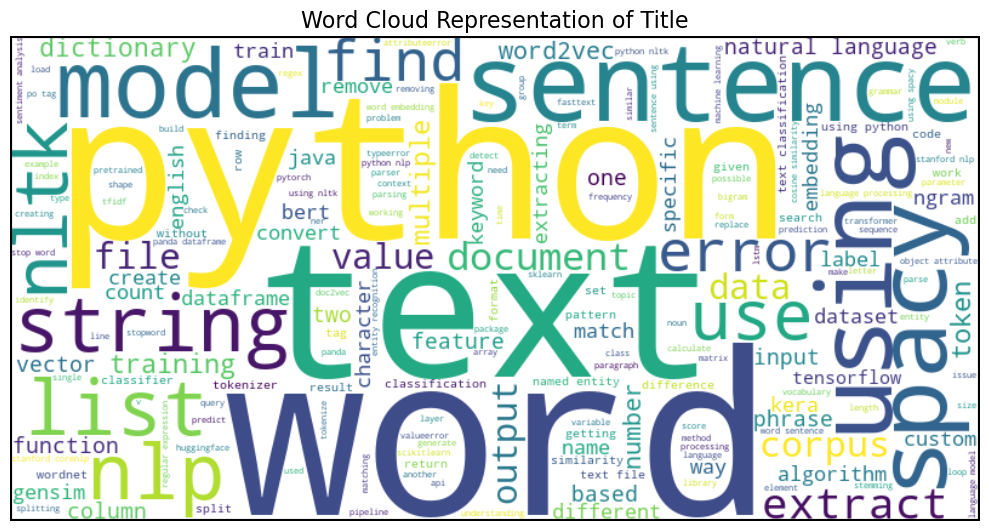

In [240]:
# Text to be visualized
text_title = df['title'] 
# Preprocess the text
text_title = text_title.apply(lambda x: ' '.join(x))
# Visualize the word cloud
visualize_data_wordcloud(text_title.tolist(), title = 'Word Cloud Representation of Title')

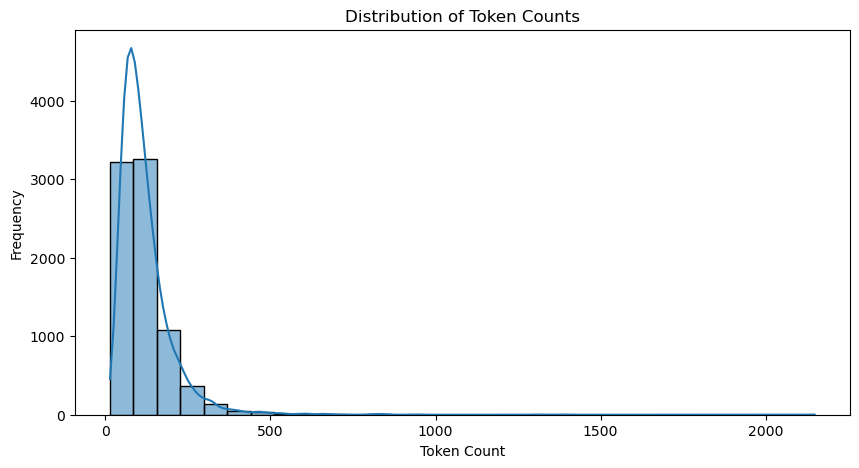

In [244]:
# Distribution of the number of tokens
def plot_token_distribution(text_list):
    '''
    Plot the distribution of token counts in the text list.
    
    Args:
        text_list (list): A list of preprocessed text strings.
    '''
    # Calculate token counts
    token_counts = [len(text.split()) for text in text_list]

    # Plot histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(token_counts, bins=30, kde=True)
    plt.title("Distribution of Token Counts")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.show()

# Plot the distribution of token counts
all_combined_text = df['title'].apply(lambda x: ' '.join(x)) + ' ' + df['body'].apply(lambda x: ' '.join(x)) + ' ' + df['accepted_answer'].apply(lambda x: ' '.join(x))
plot_token_distribution(all_combined_text.tolist())

The number of token will affect the BERT embedding vector, as the maximum token that can be embed with SBERT is 512 tokens. For all of the posts that contain less than 512 tokens, the BERT embedding will use all of the token for embedding. However for the post that has more than 512 token, BERT will automatically truncate the token to 512. We use default truncation (cut off tokens from the end if too long)

# DATA CATEGORIZATION

## Text Embedding

We use pre-trained SBERT (Sentence BERT) model to obtain the embedding vector of all documents and the topics. For the document, we just encode each document to get our document embedding matrix with size 8165 x 768. For the topics, we first embed each description of the topic separately, and then calculate the mean vector of the descriptions. This mean vector will be our topic embedding (Schopf et al, 2022).

In [ ]:
# Import the SentenceTransformer model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

# Function to embed documents using a pretrained SentenceTransformer
def embed_docs(text_list, model):
    '''
    Embed documents using pretrained SentenceTransformer.
    
    Args:
        text_list (list): A list of raw text strings.
    
    Returns:
        list: A list of embedded document vectors.
    '''
    # Embed the documents
    embeddings = model.encode(text_list.tolist(), convert_to_tensor=True, show_progress_bar=True, truncation=True)
    # Convert to numpy array
    embeddings = embeddings.cpu().numpy()
    return embeddings


# Function to embed topics using a pretrained SentenceTransformer
def embed_topics(topic_dict, model):
    '''
    Embed topics using pretrained SentenceTransformer.
    
    Args:
        topic_dict (dict): A dictionary of topics and their corresponding descriptions.
    
    Returns:
        list: A list of embedded topic vectors.
    '''
    topic_embeddings = {}
    for topic, descriptions in topic_dict.items():
        embeddings = model.encode(descriptions) # Embed each description
        avg_embedding = np.mean(embeddings, axis=0) # Calculate the mean vector of the embeddings
        topic_embeddings[topic] = avg_embedding
    
    topic_embeddings_array = np.array(list(topic_embeddings.values()))
    return topic_embeddings_array

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Below is the topic and their corresponding descriptions in dictionary data format. 

In [ ]:
topic_description = {
    "Text Preprocessing": [
        "Preprocessing involves cleaning text data using methods like lemmatization, stemming, and removing stopwords.",
        "To prepare text for NLP tasks, we often normalize it by reducing words to their base forms and filtering out irrelevant words.",
        "Text cleaning is a critical step before modeling, which includes removing common stopwords and reducing word variation.",
        "Techniques like stemming and lemmatization help reduce dimensionality by standardizing similar word forms.",
    ],
    "Python NLP Libraries": [
        "NLTK is a foundational library for text processing in Python, offering tokenization and more.",
        "Gensim is widely used for topic modeling and document similarity using techniques like LDA.",
        "The HuggingFace Transformers library enables the use of powerful pre-trained models like BERT for downstream NLP tasks.",
        "These libraries provide tools deep learning integration in NLP pipelines.",
    ],
    "POS and NER": [
        "Part-of-Speech tagging identifies the grammatical roles of words, such as nouns and verbs.",
        "Named Entity Recognition extracts named entities like people, organizations, and locations from text.",
        "POS and NER are foundational NLP tasks for understanding sentence structure and extracting semantic units.",
        "NER systems are essential for building information extraction and question answering systems.",
    ],
    "NLP with Java": [
        "Stanford NLP and OpenNLP are Java-based tools used for tasks like parsing, coreference resolution, and NER.",
        "Java NLP libraries provide robust tools for academic and production-level natural language processing.",
        "Using Java frameworks, one can build pipelines for tokenization, syntactic analysis, and entity recognition.",
        "Stanford NLP is often used in research and educational settings for deep linguistic analysis.",
    ],
    "Pandas for NLP": [
        "Pandas DataFrames make it easy to organize, clean, and process text data in Python.",
        "NLP projects often rely on Pandas for tasks like loading CSVs, filtering text, and joining metadata.",
        "Text preprocessing and feature engineering are streamlined using Pandas operations on structured datasets.",
        "Using Pandas, one can handle large collections of documents efficiently before passing them to models.",
    ],
    "Text Feature Extraction": [
        "TF-IDF is a statistical method that reflects the importance of words across a set of documents.",
        "Word2Vec learns vector representations of words based on context, enabling semantic similarity comparisons.",
        "Text representation techniques turn raw text into numeric features suitable for machine learning models.",
        "Embedding techniques like Word2Vec and GloVe capture relationships between words in a continuous space.",
    ],
    "Sentiment Analysis": [
        "Sentiment analysis detects positive, negative, or neutral emotions in text.",
        "Tools like VADER are optimized for social media and short informal texts.",
        "TextBlob provides sentiment polarity and subjectivity scores using rule-based methods.",
        "Sentiment analysis is commonly used for analyzing customer reviews and social feedback.",
    ],
    "Evaluation Metrics": [
        "Precision measures how many predicted positives are actually relevant.",
        "Recall indicates how many actual positives were correctly identified.",
        "F1-score balances precision and recall to give a single performance metric.",
        "Accuracy measures overall correctness, but can be misleading in imbalanced datasets.",
    ],
    "Unsupervised Text Classification": [
        "Unsupervised text classification groups documents without labeled data using clustering techniques.",
        "KMeans and Agglomerative Clustering identify natural groupings in the data based on vector similarity.",
        "This method helps uncover hidden structures or themes in large text corpora.",
        "Clustering can be combined with dimensionality reduction for visualizing document groups.",
    ]
}

In [ ]:
# Use combined text (title, body, answer) to get more representative semantice meaning of the post for embedding
##all_combined_text = data['title'] + '.' + data['body'] + '.' + data['accepted_answer']

# Embedding the preprocessed documents
##preprocessed_doc = all_combined_text.apply(lambda x: ' '.join(text_preprocess(x)))
##preprocessed_doc_embeddings = embed_docs(preprocessed_doc, model)

# Embedding the topics
##topic_embeddings = embed_topics(topic_description, model)



Batches: 100%|██████████| 256/256 [05:32<00:00,  1.30s/it]


In [451]:
# Check the shape of the embeddings
print("Shape of the embeddings:")
print("Topic Embeddings:", topic_embeddings.shape)
print("Preprocessed Document Embeddings:", preprocessed_doc_embeddings.shape)

Shape of the embeddings:
Topic Embeddings: (9, 768)
Preprocessed Document Embeddings: (8165, 768)


In [53]:
def calc_similarity(doc_embeddings, topic_embeddings):
    '''
    Calculate cosine similarity between document and topic embeddings.
    
    Args:
        doc_embeddings (numpy.ndarray): Document embeddings.
        topic_embeddings (numpy.ndarray): Topic embeddings.
    
    Returns:
        df similarity 
    '''
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(doc_embeddings, topic_embeddings)
    similarity_df = pd.DataFrame(similarity_matrix, columns=topic_description.keys())

    return similarity_df

In [57]:
preproc_doc_similarity_df = calc_similarity(preprocessed_doc_embeddings, topic_embeddings)
preproc_doc_similarity_df.head()

,Text Preprocessing,Python NLP Libraries,POS and NER,NLP with Java,Pandas for NLP,Text Feature Extraction,Sentiment Analysis,Evaluation Metrics,Unsupervised Text Classification
0,-0.059811,-0.004527,-0.063944,-0.055466,-0.031572,0.008284,-0.011910,-0.044573,-0.018054
1,0.437980,0.441138,0.445781,0.410271,0.377031,0.339896,0.309846,0.151665,0.306591
2,0.450358,0.510418,0.482043,0.531985,0.370827,0.368462,0.291695,0.168823,0.313155
3,0.256413,0.339360,0.277876,0.220832,0.122634,0.378181,0.305917,0.217194,0.148533
4,0.083291,0.095239,0.036638,0.048682,-0.016375,0.042089,0.062154,0.009531,0.048462


In [313]:
def filter_documents_by_similarity(similarity_df, threshold=0.5):
    '''
    Filter documents based on similarity scores.
    
    Args:
        similarity_df (pd.DataFrame): DataFrame containing similarity scores.
        threshold (float): Similarity threshold for filtering.
    
    Returns:
        pd.DataFrame: Filtered DataFrame with documents above the threshold.
    '''
    filtered_docs = similarity_df[similarity_df.gt(threshold).any(axis=1)]

    # Normalize the similarity scores
    #filtered_docs = filtered_docs.div(filtered_docs.sum(axis=1), axis=0)
    filtered_docs['topic'] = filtered_docs.idxmax(axis=1)
    return filtered_docs

In [439]:
# Function to calculate silhouette score for 10 topics
def calculate_silhouette_score(similarity_df, doc_embeddings, topic_description, topic_names, debug=False):
    '''
    Calculates the silhouette score for the document embeddings grouped by topic.

    Args:
        similarity_df (pd.DataFrame): DataFrame with a 'topic' column.
        doc_embeddings (np.ndarray): Document embeddings (num_docs x embedding_dim).
        topic_description (dict): Mapping of topic names to descriptions.
        topic_names (list): List of topic names to include.
        debug (bool): If True, print debug info.

    Returns:
        float: Silhouette score (higher is better). Returns None if not enough data.
    '''
    doc_cluster_labels = []
    doc_embedding_list = []

    for topic_id, topic_name in enumerate(topic_names):
        if topic_name not in topic_description:
            if debug:
                print(f"Warning: '{topic_name}' not in topic_description. Skipping.")
            continue

        doc_indices = similarity_df[similarity_df['topic'] == topic_name].index
        if len(doc_indices) == 0:
            if debug:
                print(f"Note: No documents found for topic '{topic_name}'. Skipping.")
            continue

        doc_embeds = doc_embeddings[doc_indices]
        doc_embedding_list.append(doc_embeds)
        doc_cluster_labels.extend([topic_id] * len(doc_embeds))

        if debug:
            print(f"Topic '{topic_name}': {len(doc_embeds)} docs")

    if not doc_embedding_list:
        print("No embeddings to evaluate.")
        return None

    # Stack document embeddings
    stacked_docs = np.vstack(doc_embedding_list)

    # Compute silhouette score
    if len(set(doc_cluster_labels)) < 2:
        print("Need at least 2 clusters to compute silhouette score.")
        return None

    score = silhouette_score(stacked_docs, doc_cluster_labels, metric='cosine')
    if debug:
        print(f"Silhouette Score: {score:.4f}")
    return score



# Plotting function for document and topic embeddings using PCA
def plot_topic_embeddings_pca(similarity_df, doc_embeddings, topic_embeddings, topic_description, topic_names, debug=False):
    '''
    Plots document and topic embeddings in 2D space using PCA for given topics.
    Also calculates the silhouette score for document clusters.

    Args:
        similarity_df (pd.DataFrame): DataFrame with a 'topic' column.
        doc_embeddings (np.ndarray): Document embeddings (num_docs x embedding_dim).
        topic_embeddings (np.ndarray): Topic embeddings (num_topics x embedding_dim).
        topic_description (dict): Mapping of topic names to descriptions.
        topic_names (list): List of topic names to include in the plot.
        debug (bool): If True, print debug info.
    '''
    all_embeddings = []
    labels = []
    topic_styles = {}

    doc_cluster_labels = []     # For silhouette score
    doc_embedding_list = []     # Just documents (no topics)

    # Prepare colors and markers
    base_colors = ['red', 'purple', 'green', 'orange', 'blue', 'brown', 'pink', 'cyan', 'olive', 'teal']
    base_markers = ['v', 'x', '+', '^', 'o', 's', 'D', '*', 'P', 'H']
    color_cycle = cycle(base_colors)
    marker_cycle = cycle(base_markers)

    # Collect embeddings
    for topic_id, topic_name in enumerate(topic_names):
        if topic_name not in topic_description:
            print(f"Warning: '{topic_name}' not in topic_description. Skipping.")
            continue

        doc_indices = similarity_df[similarity_df['topic'] == topic_name].index
        if len(doc_indices) == 0:
            print(f"Note: No documents found for topic '{topic_name}'. Skipping.")
            continue

        topic_idx = list(topic_description.keys()).index(topic_name)
        topic_embed = topic_embeddings[topic_idx]
        doc_embeds = doc_embeddings[doc_indices]

        # Track styles for consistent plotting
        topic_styles[topic_name] = {
            'color': next(color_cycle),
            'marker': next(marker_cycle)
        }

        # Add topic embedding
        all_embeddings.append(topic_embed[np.newaxis, :])
        labels.append((topic_name, "topic"))

        # Add document embeddings
        all_embeddings.append(doc_embeds)
        labels.extend([(topic_name, "doc")] * len(doc_embeds))

        # Store doc-only data for silhouette
        doc_embedding_list.append(doc_embeds)
        doc_cluster_labels.extend([topic_id] * len(doc_embeds))

        if debug:
            print(f"Topic '{topic_name}': {len(doc_embeds)} docs, topic idx = {topic_idx}")

    if not all_embeddings or not doc_embedding_list:
        print("No embeddings to plot or evaluate. Exiting function.")
        return

    # Stack all embeddings
    stacked_all = np.vstack([
        emb if emb.ndim == 2 else emb[np.newaxis, :]
        for emb in all_embeddings
    ])
    stacked_docs = np.vstack(doc_embedding_list)

    # PCA
    reduced_all = PCA(n_components=2).fit_transform(stacked_all)
    reduced_docs = PCA(n_components=2).fit_transform(stacked_docs)

    # Silhouette score
    silhouette = silhouette_score(stacked_docs, doc_cluster_labels, metric='cosine')
    print(f"\nSilhouette Score: {silhouette:.4f}")

    # Plot
    plt.figure(figsize=(14, 8))
    index = 0
    while index < len(labels):
        topic_name, label_type = labels[index]
        style = topic_styles[topic_name]

        if label_type == "topic":
            point = reduced_all[index]
            plt.scatter(point[0], point[1], color='black', marker='X', s=60)
            plt.text(point[0], point[1], topic_name, fontsize=9, ha='center', va='bottom', color='black')
            index += 1
        else:
            j = index
            while j < len(labels) and labels[j][0] == topic_name and labels[j][1] == "doc":
                j += 1
            points = reduced_all[index:j]
            plt.scatter(points[:, 0], points[:, 1],
                        alpha=0.6,
                        marker=style['marker'],
                        color=style['color'],
                        label=f"{topic_name}")
            index = j

    plt.title("Document & Topic Embeddings in 2D (PCA)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(fontsize=7, handlelength=1.5, markerscale=0.8)
    plt.grid(False)
    plt.show()


In [315]:
# Get all topic names
topic_names = list(topic_description.keys())

To find the best similarity treshold, we tried various values, and pick the best. However, since all categorized have to be populated, we limit the maximum values such all categories have at least 10 documents

In [ ]:
# Calculate silhouette score for various similarity thresholds

thresholds = [0.3, 0.4, 0.46, 0.48, 0.5]
silhouette_scores = []

for threshold in thresholds:
    filtered_similarity_df = filter_documents_by_similarity(preproc_doc_similarity_df, threshold)
    score = calculate_silhouette_score(filtered_similarity_df, preprocessed_doc_embeddings, topic_description, topic_names)
    silhouette_scores.append(score)
    print(f"Threshold: {threshold}, Silhouette Score: {score:.4f}")
    

Threshold: 0.3, Silhouette Score: 0.0293
Threshold: 0.4, Silhouette Score: 0.0389
Threshold: 0.46, Silhouette Score: 0.0511
Threshold: 0.48, Silhouette Score: 0.0571
Threshold: 0.5, Silhouette Score: 0.0623


Topic 'Text Preprocessing': 478 docs, topic idx = 0
Topic 'Python NLP Libraries': 379 docs, topic idx = 1
Topic 'POS and NER': 600 docs, topic idx = 2
Topic 'NLP with Java': 393 docs, topic idx = 3
Topic 'Pandas for NLP': 145 docs, topic idx = 4
Topic 'Text Feature Extraction': 758 docs, topic idx = 5
Topic 'Sentiment Analysis': 161 docs, topic idx = 6
Topic 'Evaluation Metrics': 12 docs, topic idx = 7
Topic 'Unsupervised Text Classification': 111 docs, topic idx = 8

Silhouette Score: 0.0511


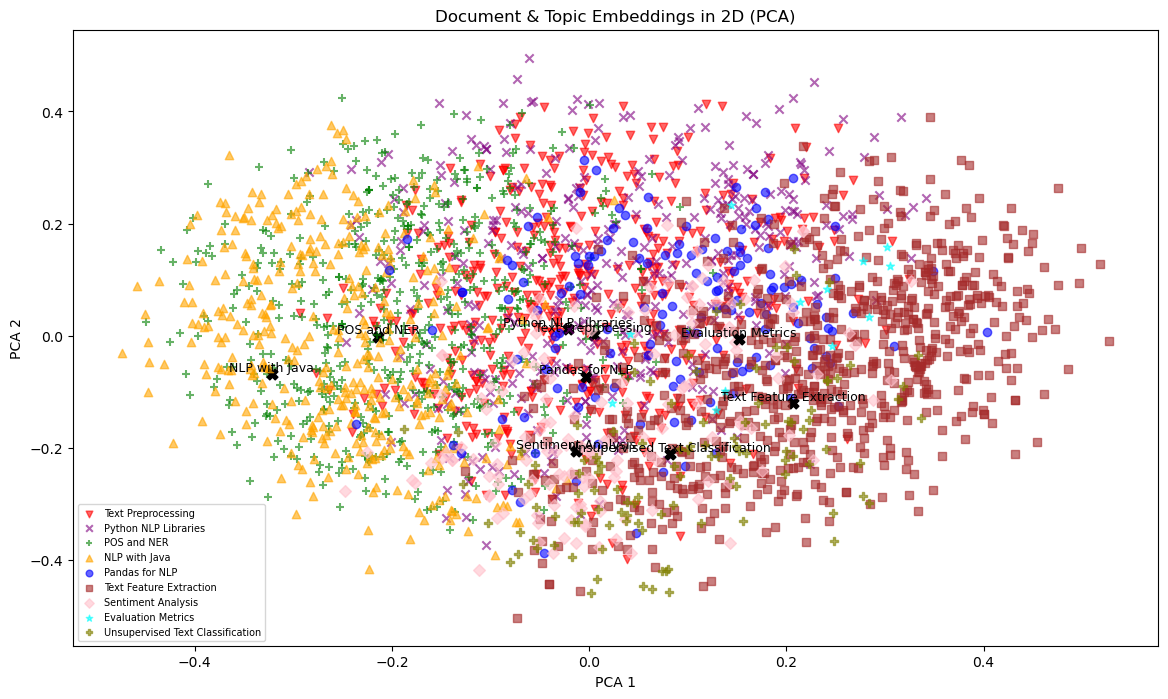

In [440]:
filtered_similarity_df = filter_documents_by_similarity(preproc_doc_similarity_df, 0.46)

visualize_topic_names = ["POS and NER", "NLP with Java"]

plot_topic_embeddings_pca(similarity_df=filtered_similarity_df,
                        doc_embeddings=preprocessed_doc_embeddings,
                        topic_embeddings=topic_embeddings,
                        topic_description=topic_description,
                        topic_names=topic_names,
                        debug=True
                        )

In [ ]:
# Save embedding pkl
import pickle
with open("embedding/preproc_doc_embedding.pkl", "wb") as f:
    pickle.dump(preprocessed_doc_embeddings, f)

with open("embedding/topic_embedding.pkl", "wb") as f:
    pickle.dump(topic_embeddings, f)

In [ ]:
# Import embeeddingdings pkl
import pickle
with open("embedding/preproc_doc_embedding.pkl", "rb") as f:
    preprocessed_doc_embeddings = pickle.load(f)
with open("embedding/topic_embedding.pkl", "rb") as f:
    topic_embeddings = pickle.load(f)


### Final Categorization Dataframe

In [411]:
# Ensure 'index' is a column in filtered_similarity_df (not just the index)
filtered_similarity_df = filtered_similarity_df.reset_index()

# Merge based on the index (document IDs)
final_categorized_df = pd.merge(
    filtered_similarity_df,                  # has index + topic
    df[['title', 'body', 'tags', 'accepted_answer']],  # original content
    left_on='index', right_index=True,       # match index from filtered_similarity_df to df's index
    how='inner'                              # or 'left' if you want to keep all rows in filtered_similarity_df
)

# Optional: reorder columns for clarity
final_categorized_df = final_categorized_df[['index', 'title', 'body', 'tags', 'accepted_answer', 'topic']]


In [412]:
topic_to_indices = (
    filtered_similarity_df
    .groupby('topic')['index']
    .apply(list)
    .to_dict()
)

In [424]:
title = final_categorized_df.loc[final_categorized_df['index'] == 1630, 'title'].values[0]
print(title)

How to count collocations in quanteda based on grouping variables?


In [453]:
len(filtered_similarity_df)

3037